In [1]:
import warnings
warnings.filterwarnings("ignore")
import modulesForCalibration as mfc
import matplotlib.pyplot as plt

#import readPlotOptionSurface_granular_k2_5 as marketSurface
import readPlotOptionSurfaceedited as marketSurface
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin


import plotly.plotly as py
import plotly.graph_objs as go

<Figure size 800x600 with 1 Axes>

# This report reflects the work of Lisa He, Alban Zapke, and Naijia Yao, for the project of volatility surface in Computational Methods in Finance with Prof. Hirsa.

## APPL

###  We set up Grid for Model Prices as provided in readPlotOptionSurface.py provided by Prof. Hirsa

### deltaK = 5 & deltaTau = 1/52

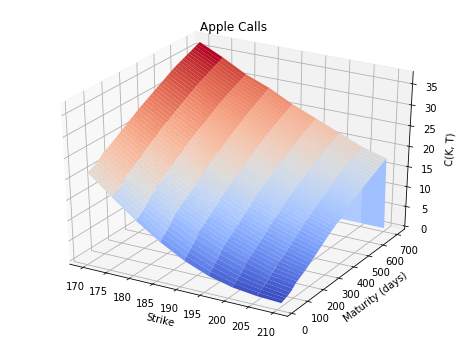

In [2]:
maturities, strikes, marketPrices = marketSurface.readNPlot()

In [3]:
maturities_years = maturities/365

# I. Model Prices

### Global Parameters

In [4]:
# Contract Parameters
S0 = 190
K = 190
k = np.log(K)
# risk free rate
r = 0.0245
# dividend rate
q = 0.005

# Parameters
alpha = 1.5                       # Why?
eta = 0.2

n = 12
N = 2**n

# step-size in log strike space  --> FFT constraint
#lda = (2*np.pi/N)/eta

# Choice of beta
#beta = np.log(S0)-N*lda/2
# beta = np.log(K)

* Grid for Model Prices was set up in readPlotOptionSurface

## 1. Finding a starting point; code provided as in exampleCalibration_FindingStartingPoint.py by Prof. Hirsa

In [5]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10                          # Random; in order to have an error to start with

### Model specific parameters:

#### Heston 

In [6]:
model = 'Heston'

#set 1: promising starting point
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

In [7]:
lenT = len(maturities_years)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

In [8]:
modelPrices.shape == marketPrices.shape

True

In [9]:
marketPrices.shape


(98, 9)

In [10]:
iArray = []
rmseArray=[]
for i in mfc.myRange(0.0, 1.0, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

In [27]:
len(rmseArray) == len(iArray)
print(len(rmseArray))
print(len(iArray))
#print(rmseArray)
#print(iArray)

20
20


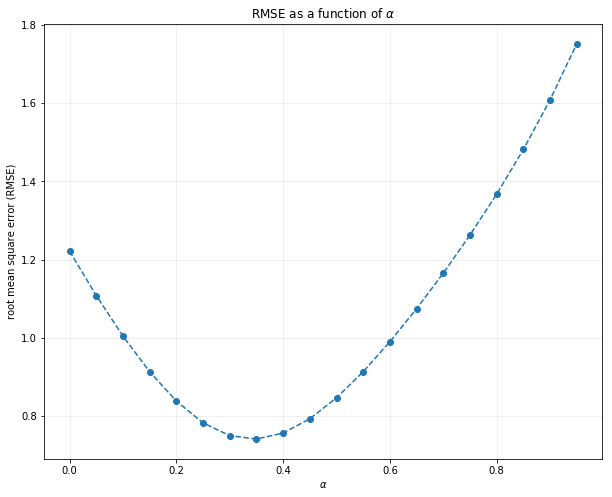

0.7410834358357488
[ 2.3     0.046   0.0825 -0.53    0.054 ]


In [28]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.savefig('startingPoint4.png')
plt.show()

print(rmseMin)
print(optimParams)

In [29]:
# Starting point Parameters 
kappa = 2.3
theta = 0.046
sig = 0.0825
rho = -0.53
v0 = 0.054

## 2. Optimization of Parameter Set

#### - Objective Function -

In [30]:
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [31]:
lenT = len(maturities)
lenK = len(strikes)

#### A) Brute Force Algorithm 

In [33]:
# maturities, strikes, marketPrices = marketSurface.readNPlot()

#==========================================
# Grid Search around the starting point
#------------------------------------------
# [ 2.3     0.046   0.0825 -0.53    0.054 ]
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(1.8,2.8,0.5):
    for theta in mfc.myRange(0.036,0.056,0.01):
        for sig in mfc.myRange(0.0725,0.0925,0.01):
            for rho in mfc.myRange(-0.63,-0.43,0.1):
                for v0 in mfc.myRange(0.044,0.064,0.01):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

i = 1
[1.7, 0.034, 0.07, -0.62, 0.046]

new min found
0.9061558281366756
[1.7, 0.034, 0.07, -0.62, 0.046]

i = 2
[1.7, 0.034, 0.07, -0.62, 0.056]

new min found
0.7495517706837034
[1.7, 0.034, 0.07, -0.62, 0.056]

i = 3
[1.7, 0.034, 0.07, -0.62, 0.066]
i = 4
[1.7, 0.034, 0.07, -0.52, 0.046]
i = 5
[1.7, 0.034, 0.07, -0.52, 0.056]
i = 6
[1.7, 0.034, 0.07, -0.52, 0.066]
i = 7
[1.7, 0.034, 0.07, -0.42000000000000004, 0.046]
i = 8
[1.7, 0.034, 0.07, -0.42000000000000004, 0.056]
i = 9
[1.7, 0.034, 0.07, -0.42000000000000004, 0.066]
i = 10
[1.7, 0.034, 0.08, -0.62, 0.046]
i = 11
[1.7, 0.034, 0.08, -0.62, 0.056]

new min found
0.7480136822229901
[1.7, 0.034, 0.08, -0.62, 0.056]

i = 12
[1.7, 0.034, 0.08, -0.62, 0.066]
i = 13
[1.7, 0.034, 0.08, -0.52, 0.046]
i = 14
[1.7, 0.034, 0.08, -0.52, 0.056]
i = 15
[1.7, 0.034, 0.08, -0.52, 0.066]
i = 16
[1.7, 0.034, 0.08, -0.42000000000000004, 0.046]
i = 17
[1.7, 0.034, 0.08, -0.42000000000000004, 0.056]
i = 18
[1.7, 0.034, 0.08, -0.42000000000000004, 0.

i = 143
[2.2, 0.054000000000000006, 0.07, -0.42000000000000004, 0.056]
i = 144
[2.2, 0.054000000000000006, 0.07, -0.42000000000000004, 0.066]
i = 145
[2.2, 0.054000000000000006, 0.08, -0.62, 0.046]
i = 146
[2.2, 0.054000000000000006, 0.08, -0.62, 0.056]
i = 147
[2.2, 0.054000000000000006, 0.08, -0.62, 0.066]
i = 148
[2.2, 0.054000000000000006, 0.08, -0.52, 0.046]
i = 149
[2.2, 0.054000000000000006, 0.08, -0.52, 0.056]
i = 150
[2.2, 0.054000000000000006, 0.08, -0.52, 0.066]
i = 151
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.046]
i = 152
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.056]
i = 153
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.066]
i = 154
[2.2, 0.054000000000000006, 0.09, -0.62, 0.046]
i = 155
[2.2, 0.054000000000000006, 0.09, -0.62, 0.056]
i = 156
[2.2, 0.054000000000000006, 0.09, -0.62, 0.066]
i = 157
[2.2, 0.054000000000000006, 0.09, -0.52, 0.046]
i = 158
[2.2, 0.054000000000000006, 0.09, -0.52, 0.056]
i = 159
[2.2, 0.0540000000000

In [ ]:
# Solution of grid search:
# [1.7, 0.044000000000000004, 0.09, -0.62, 0.046]
# Optimal rmse = 0.3822081498347296

#### - Market vs. Model Surface -

In [34]:
params2

[1.7, 0.044000000000000004, 0.09, -0.62, 0.046]

In [35]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [36]:
modelPrices.shape == marketPrices.shape

True

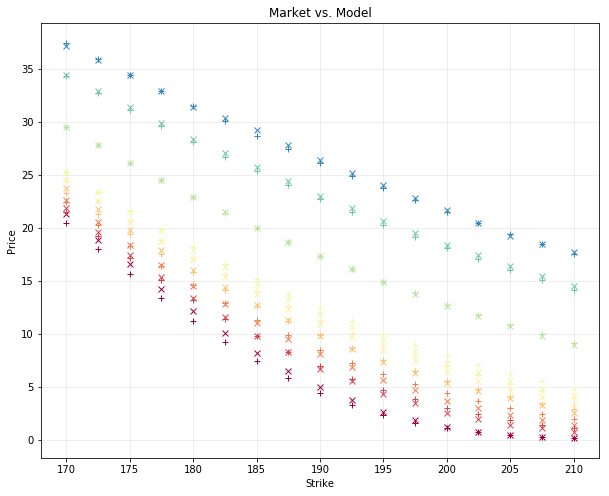

In [37]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
    
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')
plt.savefig('MarketvsModel_GridSearch.png')
plt.show() 

#### B) Nelder Mead Algorithm  (Gradient-free) from exampleCalibration_NelderMead.py

In [316]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================
# [ 2.3     0.046   0.0825 -0.53    0.054 ]

params = [ 2.3   ,  0.046 ,  0.0825 ,-0.53 ,   0.054 ]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=200,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 2.266    0.0396   0.0824  -0.5356   0.05768]
f_i = 0.5999402451624422
i = 2
x_i = [ 2.3056    0.04136   0.08384  -0.54496   0.051408]
f_i = 0.42666037838617843
i = 3
x_i = [ 2.3056    0.04136   0.08384  -0.54496   0.051408]
f_i = 0.42666037838617843
i = 4
x_i = [ 2.3056    0.04136   0.08384  -0.54496   0.051408]
f_i = 0.42666037838617843
i = 5
x_i = [ 2.3056    0.04136   0.08384  -0.54496   0.051408]
f_i = 0.42666037838617843
i = 6
x_i = [ 2.3056    0.04136   0.08384  -0.54496   0.051408]
f_i = 0.42666037838617843
i = 7
x_i = [ 2.49878886  0.04269028  0.08596905 -0.54232522  0.04635825]
f_i = 0.3534186703723513
i = 8
x_i = [ 2.49878886  0.04269028  0.08596905 -0.54232522  0.04635825]
f_i = 0.3534186703723513
i = 9
x_i = [ 2.49878886  0.04269028  0.08596905 -0.54232522  0.04635825]
f_i = 0.3534186703723513
i = 10
x_i = [ 2.49878886  0.04269028  0.08596905 -0.54232522  0.04635825]
f_i = 0.3534186703723513
i = 11
x_i = [ 2.49878886  0.04269028  0.08596905 -0.54232522  0.0463

f_i = 0.2055644665110863
i = 84
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 85
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 86
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 87
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 88
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 89
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 90
x_i = [ 3.05765215  0.04702068  0.14425245 -0.75776744  0.03973954]
f_i = 0.2055644665110863
i = 91
x_i = [ 3.06799906  0.04701001  0.14475348 -0.76101962  0.03976142]
f_i = 0.2055605910861548
i = 92
x_i = [ 3.06799906  0.04701001  0.14475348 -0.76101962  0.03976142]
f_i = 0.2055605910861548
i = 93
x_i = [ 3.06799906  0.04701001  0.14475348 -0.76101962  0.03976142]


f_i = 0.205161934377883
i = 165
x_i = [ 3.83363975  0.04661389  0.14240554 -0.8955673   0.03931729]
f_i = 0.20516174332579296
i = 166
x_i = [ 3.83363975  0.04661389  0.14240554 -0.8955673   0.03931729]
f_i = 0.20516174332579296
i = 167
x_i = [ 3.81982929  0.04662396  0.14255262 -0.89326105  0.03931471]
f_i = 0.20516160224353272
i = 168
x_i = [ 3.80878062  0.0466248   0.14254295 -0.89127419  0.0393287 ]
f_i = 0.20516147634167492
i = 169
x_i = [ 3.80878062  0.0466248   0.14254295 -0.89127419  0.0393287 ]
f_i = 0.20516147634167492
i = 170
x_i = [ 3.80878062  0.0466248   0.14254295 -0.89127419  0.0393287 ]
f_i = 0.20516147634167492
i = 171
x_i = [ 3.80878062  0.0466248   0.14254295 -0.89127419  0.0393287 ]
f_i = 0.20516147634167492
i = 172
x_i = [ 3.81252988  0.04662304  0.14266439 -0.89204075  0.03933429]
f_i = 0.20516105062573195
i = 173
x_i = [ 3.81252988  0.04662304  0.14266439 -0.89204075  0.03933429]
f_i = 0.20516105062573195
i = 174
x_i = [ 3.81252988  0.04662304  0.14266439 -0.8920

In [ ]:
# AT 199 ITERATIONS IT BLEW UP - MAX # OF ITERATIONS
#[ 3.82879801  0.04661798  0.14376313 -0.89199663  0.03933305]
#f = 0.20515098097908327

#### - Market vs. Model Surface -

In [38]:
params_NM = [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]
lenT = len(maturities)
lenK = len(strikes)
modelPrices_MN = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_NM, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_MN[i,j] = cT_km[0]

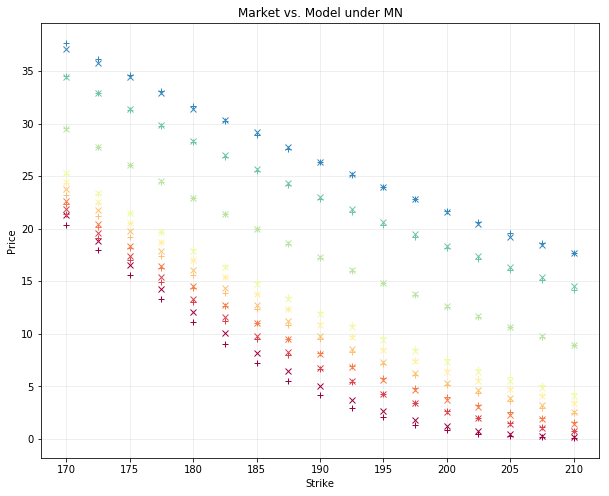

In [39]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_MN[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model under MN')
#plt.savefig('MarketvsModel_NelderMead.png')
plt.show() 

#### C) BFGS Algorithm (Gradient-based) from exampleCalibration_BFGS.py

In [44]:
import warnings
warnings.filterwarnings("ignore")

import readPlotOptionSurface 
import modulesForCalibration as mfc

from scipy.optimize import fmin_bfgs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

params = [ 2.3,     0.046 ,  0.0825 ,-0.53  ,  0.054 ]

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

print('optimal params = ')
print(xopt)
print('f = ' + str(fopt))


 
i = 1
x_i = [ 2.30000933  0.03976261  0.08258009 -0.53000747  0.04813749]
f_i = 0.5369125315296658
 
i = 2
x_i = [ 2.30001144  0.04317609  0.08272487 -0.53002916  0.04179787]
f_i = 0.46072398862013314
 
i = 3
x_i = [ 2.33026752  0.04588309  0.21801585 -0.55012924  0.04134229]
f_i = 0.3662316103511714
 
i = 4
x_i = [ 2.37026569  0.04765539  0.1975895  -0.54910741  0.04115752]
f_i = 0.3211739202480106
 
i = 5
x_i = [ 2.37348347  0.04704073  0.22614396 -0.57784545  0.04361032]
f_i = 0.31514088046246974
 
i = 6
x_i = [ 2.38705214  0.04739526  0.22906021 -0.57220899  0.04277752]
f_i = 0.313251725805429
 
i = 7
x_i = [ 2.43903372  0.04746071  0.2448277  -0.5199881   0.04265592]
f_i = 0.31240909739188943
 
i = 8
x_i = [ 2.54290583  0.04763839  0.28286388 -0.431771    0.04267665]
f_i = 0.3112141393930959
 
i = 9
x_i = [ 2.65751598  0.04785946  0.32979541 -0.36291643  0.04289731]
f_i = 0.30979083155613935
 
i = 10
x_i = [ 2.75773659  0.04807037  0.37338272 -0.33428837  0.04324972]
f_i = 0.307

In [ ]:
#optimal params = 
#[ 3.63793835  0.04837702  0.60186371 -0.2696817   0.04564052]
#f = 0.29430818842741424

In [46]:

        
params_BFGS = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices_BFGS = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_BFGS, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_BFGS[i,j] = cT_km[0]

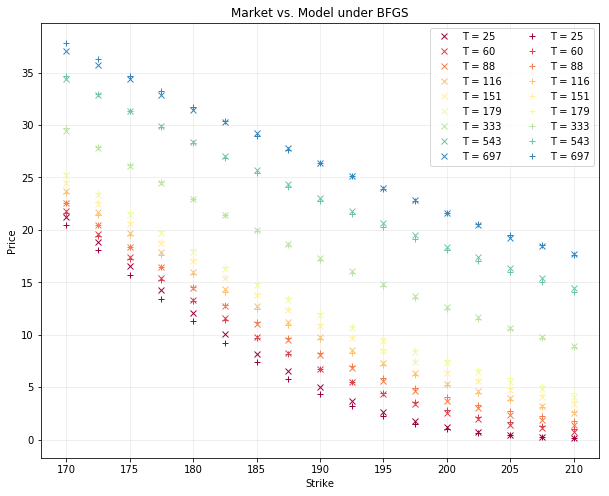

In [47]:

# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_BFGS[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model under BFGS')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


### Evaluate which Optimization yields best results: Loss Function

In [49]:
# set 1: Brute-Force vs. Nelder-Mead
params_BF = [1.7, 0.044000000000000004, 0.09, -0.62, 0.046]
params_NM = [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]

In [50]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_NM)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 4.89319702  0.04792697  0.1706447  -1.02799494  0.03599957]

-0.45
[ 4.78675711  0.04779607  0.16795654 -1.01439511  0.03633292]

-0.4
[ 4.68031721  0.04766517  0.16526838 -1.00079528  0.03666627]

-0.35000000000000003
[ 4.57387731  0.04753427  0.16258023 -0.98719545  0.03699962]

-0.30000000000000004
[ 4.46743741  0.04740337  0.15989207 -0.97359562  0.03733297]

-0.25000000000000006
[ 4.36099751  0.04727248  0.15720391 -0.95999579  0.03766631]

-0.20000000000000007
[ 4.25455761  0.04714158  0.15451576 -0.94639596  0.03799966]

-0.15000000000000008
[ 4.14811771  0.04701068  0.1518276  -0.93279612  0.03833301]

-0.10000000000000007
[ 4.04167781  0.04687978  0.14913944 -0.91919629  0.03866635]

-0.05000000000000007
[ 3.93523791  0.04674888  0.14645129 -0.90559646  0.0389997 ]

-6.938893903907228e-17
[ 3.82879801  0.04661798  0.14376313 -0.89199663  0.03933305]

0.04999999999999993
[ 3.72235811  0.04648708  0.14107497 -0.8783968   0.0396664 ]

0.09999999999999994
[ 3.61591821  0.0

In [ ]:
#optimal results are:
#0.32557393153218905
#[ 3.50947831  0.04622528  0.13569866 -0.85119714  0.04033309]
#NM is better

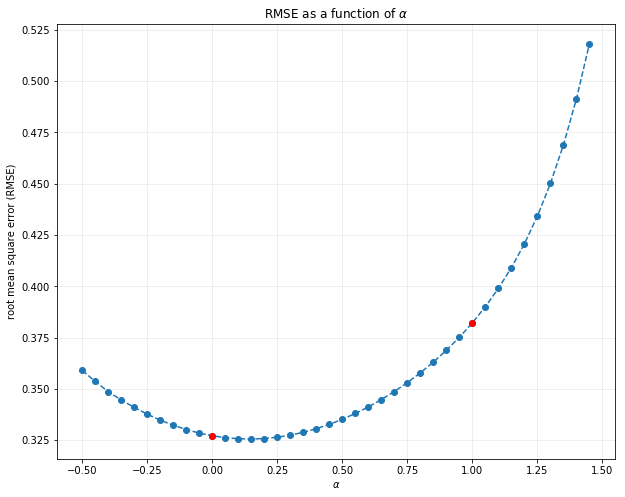

In [51]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

***Concludes that NM Parameters yield better result ***

In [52]:
# set 2: Brute-Force vs. BFGS
params_BF = [1.7, 0.044000000000000004, 0.09, -0.62, 0.046]
params_BFGS = [ 3.63793835 , 0.04837702 , 0.60186371 ,-0.2696817 ,  0.04564052]

In [53]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 4.60690753  0.05056553  0.85779557 -0.09452255  0.04546078]

-0.45
[ 4.51001061  0.05034668  0.83220238 -0.11203846  0.04547875]

-0.4
[ 4.41311369  0.05012783  0.80660919 -0.12955438  0.04549673]

-0.35000000000000003
[ 4.31621677  0.04990898  0.78101601 -0.1470703   0.0455147 ]

-0.30000000000000004
[ 4.21931986  0.04969013  0.75542282 -0.16458621  0.04553268]

-0.25000000000000006
[ 4.12242294  0.04947127  0.72982964 -0.18210213  0.04555065]

-0.20000000000000007
[ 4.02552602  0.04925242  0.70423645 -0.19961804  0.04556862]

-0.15000000000000008
[ 3.9286291   0.04903357  0.67864327 -0.21713396  0.0455866 ]

-0.10000000000000007
[ 3.83173219  0.04881472  0.65305008 -0.23464987  0.04560457]

-0.05000000000000007
[ 3.73483527  0.04859587  0.6274569  -0.25216579  0.04562255]

-6.938893903907228e-17
[ 3.63793835  0.04837702  0.60186371 -0.2696817   0.04564052]

0.04999999999999993
[ 3.54104143  0.04815817  0.57627052 -0.28719762  0.04565849]

0.09999999999999994
[ 3.44414452  0.0

In [ ]:
#optimal results are 
#0.29430818581882634
#[ 3.63793835  0.04837702  0.60186371 -0.2696817   0.04564052]

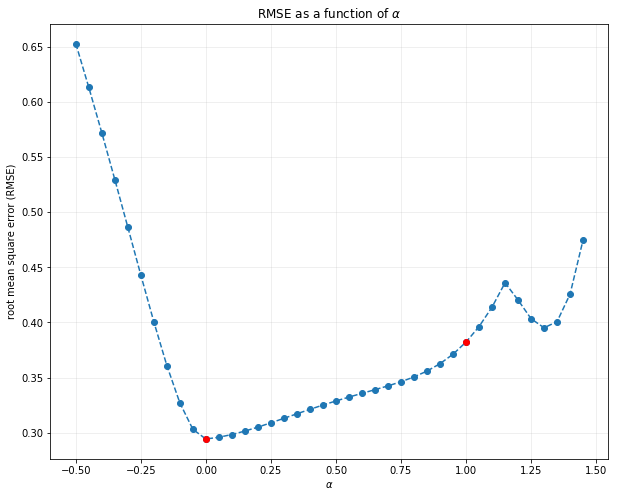

In [54]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

In [ ]:
#BFGD yields better result

In [55]:
# set 3: NelderMead vs. BFGS
params_NM = [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]
params_BFGS = [ 3.63793835 , 0.04837702 , 0.60186371 ,-0.2696817 ,  0.04564052]

In [56]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_NM) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[3.54250852 0.04925654 0.830914   0.04147576 0.04879425]

-0.45
[3.5520515  0.04916859 0.80800897 0.01036002 0.04847888]

-0.4
[ 3.56159449  0.04908064  0.78510394 -0.02075573  0.04816351]

-0.35000000000000003
[ 3.57113747  0.04899268  0.76219891 -0.05187147  0.04784813]

-0.30000000000000004
[ 3.58068045  0.04890473  0.73929388 -0.08298722  0.04753276]

-0.25000000000000006
[ 3.59022344  0.04881678  0.71638886 -0.11410297  0.04721739]

-0.20000000000000007
[ 3.59976642  0.04872883  0.69348383 -0.14521871  0.04690201]

-0.15000000000000008
[ 3.6093094   0.04864088  0.6705788  -0.17633446  0.04658664]

-0.10000000000000007
[ 3.61885238  0.04855292  0.64767377 -0.20745021  0.04627127]

-0.05000000000000007
[ 3.62839537  0.04846497  0.62476874 -0.23856595  0.04595589]

-6.938893903907228e-17
[ 3.63793835  0.04837702  0.60186371 -0.2696817   0.04564052]

0.04999999999999993
[ 3.64748133  0.04828907  0.57895868 -0.30079745  0.04532515]

0.09999999999999994
[ 3.65702432  0.04820112  0

In [ ]:
#Optimal results are:
#0.29424796472109044
#[ 3.64748133  0.04828907  0.57895868 -0.30079745  0.04532515]

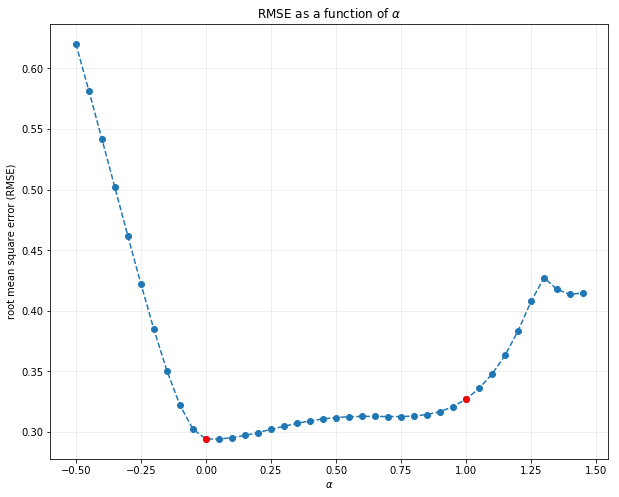

In [57]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

In [ ]:
#BFGS is the best

# II. Local Volatility Surface

** Explicitly compute local volatility for each point in our grid **

## 1. Calculate Finite differences

In [11]:
deltaK = 5
deltaT = 1/52 

In [15]:

params_BFGS = [ 3.63793835 , 0.04837702 , 0.60186371 ,-0.2696817 ,  0.04564052]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_BFGS, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [16]:
modelPrices.shape

(98, 9)

In [17]:
# v_j,k Option prices for all points on the grid
modelPrices_df = pd.DataFrame(modelPrices, columns = strikes)
modelPrices_df.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,20.440630,15.703254,11.277736,7.401358,4.333137,2.223275,0.997278,0.396668,0.143132
1,20.647614,16.010738,11.708753,7.940705,4.911118,2.739629,1.379419,0.634839,0.271969
2,20.873399,16.324738,12.121172,8.433477,5.430860,3.213591,1.751035,0.888469,0.426244
3,21.109894,16.638245,12.515266,8.890375,5.908046,3.654954,2.110730,1.149274,0.597788
4,21.351979,16.947915,12.892556,9.318729,6.352544,4.070433,2.458881,1.412864,0.781102


#### dC/dT for every point on the grid

In [18]:
dcdT = (modelPrices_df.diff()/deltaT).shift(-1)
dcdT.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,10.763172,15.989144,22.412853,28.046028,30.055008,26.850400,19.871359,12.384895,6.699522
1,11.740827,16.328011,21.445817,25.624179,27.026631,24.646026,19.324051,13.188751,8.022271
2,12.297724,16.302395,20.492861,23.758661,24.813646,22.950895,18.704099,13.561850,8.920292
3,12.588442,16.102817,19.619106,22.274414,23.113899,21.604901,18.103895,13.706706,9.532348
4,12.712139,15.823386,18.836836,21.063130,21.760838,20.508010,17.551166,13.727735,9.953967


In [19]:
(16.010738 - 15.703254)/ deltaT

15.989168000000028

#### dC/dK for every point on the grid

In [20]:
dcdK = (modelPrices_df.diff(axis=1, periods = 2)/(2*deltaK)).shift(-1,axis=1)
dcdK.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,-0.916289,-0.830190,-0.694460,-0.517808,-0.333586,-0.182661,-0.085415,NaN
1,NaN,-0.893886,-0.807003,-0.679763,-0.520108,-0.353170,-0.210479,-0.110745,NaN
2,NaN,-0.875223,-0.789126,-0.669031,-0.521989,-0.367983,-0.232512,-0.132479,NaN
3,NaN,-0.859463,-0.774787,-0.660722,-0.523542,-0.379732,-0.250568,-0.151294,NaN
4,NaN,-0.845942,-0.762919,-0.654001,-0.524830,-0.389366,-0.265757,-0.167778,NaN


In [22]:
(11.277736 - 20.440630)/(2*deltaK)

-0.9162893999999998

In [23]:
# For vol surface calculation
dcdK_v = dcdK
for i in modelPrices_df.columns:
    dcdK_v[i] = i * dcdK[i]*(r-q)

In [24]:
dcdK_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,-3.126837,-2.913965,-2.505264,-1.918480,-1.268460,-0.712377,-0.341445,NaN
1,NaN,-3.050386,-2.832581,-2.452247,-1.926999,-1.342928,-0.820868,-0.442703,NaN
2,NaN,-2.986697,-2.769832,-2.413530,-1.933968,-1.399253,-0.906798,-0.529586,NaN
3,NaN,-2.932917,-2.719503,-2.383554,-1.939723,-1.443930,-0.977215,-0.604799,NaN
4,NaN,-2.886778,-2.677844,-2.359309,-1.944494,-1.480565,-1.036452,-0.670692,NaN


In [25]:
(r-q)*175*(-0.916289)

-3.1268362125

#### d2C/dK2 for every point on the grid

In [26]:
# For d2C/dK2: - 2*v_j,k
modelPrices_df_neg2 = modelPrices_df*(-2)

In [27]:
modelPrices_df_neg2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,-40.881260,-31.406508,-22.555472,-14.802716,-8.666273,-4.446550,-1.994555,-0.793336,-0.286264
1,-41.295228,-32.021475,-23.417505,-15.881410,-9.822235,-5.479257,-2.758838,-1.269678,-0.543938
2,-41.746798,-32.649475,-24.242344,-16.866955,-10.861721,-6.427181,-3.502071,-1.776938,-0.852487
3,-42.219787,-33.276491,-25.030531,-17.780750,-11.816092,-7.309908,-4.221459,-2.298547,-1.195575
4,-42.703958,-33.895830,-25.785112,-18.637458,-12.705088,-8.140866,-4.917763,-2.825728,-1.562204


In [28]:
d2cdK2 = pd.DataFrame()
for i in range(len(modelPrices_df.columns)): 
    try:
        d2cdK2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i-1]] + modelPrices_df[modelPrices_df.columns[i+1]] -2* modelPrices_df[modelPrices_df.columns[i]])/(deltaK**2)
    except: 
        d2cdK2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))

In [29]:
modelPrices_df.shape == modelPrices_df_neg2.shape == d2cdK2.shape

True

In [30]:
d2cdK2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
d2cdK2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.012474,0.021966,0.032326,0.038334,0.035355,0.025016,0.013883,NaN
1,NaN,0.013396,0.021357,0.029538,0.034324,0.032451,0.024625,0.015268,NaN
2,NaN,0.013804,0.020635,0.027403,0.031414,0.030189,0.024000,0.016014,NaN
3,NaN,0.013947,0.019924,0.025702,0.029169,0.028355,0.023311,0.016399,NaN
4,NaN,0.013948,0.019261,0.024306,0.027363,0.026822,0.022621,0.016570,NaN


In [349]:
(15.627181 - 2* 17.977095 + 20.385484)/(deltaK**2)

0.00935600000000079

In [31]:
# For vol surface calculation
d2cdK2_v = d2cdK2
for i in modelPrices_df.columns:
    d2cdK2_v[i] = i**2 * d2cdK2[i] * 1/2

In [32]:
d2cdK2_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,191.012999,355.842620,553.183163,691.935619,672.179047,500.310079,291.715554,NaN
1,NaN,205.120967,345.991343,505.476229,619.546941,616.977958,492.503585,320.827411,NaN
2,NaN,211.371079,334.284423,468.935647,567.020655,573.960416,479.990887,336.486917,NaN
3,NaN,213.559529,322.761671,439.833656,526.509011,539.093772,466.214671,344.579821,NaN
4,NaN,213.582058,312.032542,415.931126,493.901238,509.960650,452.427236,348.181557,NaN


In [366]:
0.009356*172.5**2*0.5

139.1997375

In [33]:
dcdT.shape == modelPrices_df.shape == dcdK_v.shape == d2cdK2_v.shape

True

## 2. Calculate Local Volatility Surface

In [34]:
# Vol Surface 
vol_surface = ((dcdT + dcdK_v + q*modelPrices_df)/d2cdK2_v)**0.5

In [36]:
vol_surface

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.260285,0.234424,0.215029,0.201730,0.195128,0.195715,0.203204,NaN
1,NaN,0.255188,0.232306,0.214290,0.201377,0.194401,0.193865,0.199345,NaN
2,NaN,0.251760,0.230649,0.213561,0.200994,0.193848,0.192605,0.196834,NaN
3,NaN,0.249115,0.229245,0.212896,0.200680,0.193473,0.191724,0.195037,NaN
4,NaN,0.246914,0.228019,0.212322,0.200465,0.193265,0.191127,0.193703,NaN
5,NaN,0.245008,0.226942,0.211848,0.200357,0.193206,0.190756,0.192708,NaN
6,NaN,0.243322,0.225995,0.211472,0.200347,0.193273,0.190567,0.191978,NaN
7,NaN,0.241815,0.225169,0.211190,0.200424,0.193445,0.190530,0.191465,NaN
8,NaN,0.240463,0.224452,0.210993,0.200577,0.193705,0.190616,0.191130,NaN
9,NaN,0.239247,0.223836,0.210872,0.200794,0.194034,0.190802,0.190944,NaN


In [101]:
vol_surface_new = vol_surface[[175.0, 180.0,185.0,190.0,195.0,200.0,205.0]]
#pd.DataFrame.to_csv(vol_surface)

In [102]:
vol_surface_new = vol_surface_new.loc[np.arange(0,97)]

In [107]:
vol_surface_new.to_csv('heston_call.csv')


In [111]:
import plotly
plotly.tools.set_credentials_file(username='lisayhe', api_key='FioDIUbTjZMAu76NCdei')

In [115]:

data = [
    go.Surface(
        z=vol_surface_new.as_matrix()
    )
]
layout = go.Layout(
    title='Apple Heston Call Vol Surface',
    autosize=True,
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Apple_Heston_Call', auto_open=True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~lisayhe/0 or inside your plot.ly account where it is named 'elevations-3d-surface'
